# HW07: Deep Learning (due 16th November)

In this homework, you will replicate the heterogenous treatment effect exercise from last week's homework using a deep learning model instead of a machine learning one. 

For those who did not complete this exercise, you will investigate the effect of case management on mental health outcomes. These data come from a randomized control trial where patients were assigned to *intensive* or *standard* case management. In this context, the treatment is being assigned to the **intensive** case management while patients assigned to the **standard** case management belong to the control group.

We will investigate characteristics of individuals who are most and least responsive to the treatment, i.e., to being assigned to the intensive case management. 

In [90]:
import pandas as pd
from tensorflow import keras

In [91]:
import pandas as pd
import statsmodels.formula.api as smf

df = pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta')
df = df.dropna()
pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta', iterator=True).variable_labels()

{'trialid': 'Trial ID',
 'centreid': 'Trial centre',
 'status': 'Patient status at baseline',
 'age': 'Age in years at baseline',
 'sex': 'Sex',
 'afcarib': 'Ethnic group',
 'ocfabth': "Father's social class at birth",
 'chron1l': 'Months since onset of psychosis, logged',
 'hos94': 'Days in hospital for psychiatric reasons: 2 years before baseline',
 'cprs94': 'Psychopathology at baseline (CPRS)',
 'das94': 'Disability at baseline (DAS)',
 'sat94': '(Dis)satisfaction with services at baseline',
 'rand': 'Randomised group',
 'hos96': 'Days in hospital for psychiatric reasons: 2 years after baseline',
 'cprs96': 'Psychopathology at 2 years (CPRS)',
 'sat96': '(Dis)satisfaction with services at 2 years'}

In [92]:
df.head()

,trialid,centreid,status,age,sex,afcarib,ocfabth,chron1l,hos94,cprs94,das94,sat94,rand,hos96,cprs96,sat96
1,107.0,St George's,Out-patient,27.0,male,Other,A,3.178054,80.0,4.0,0.285714,18.0,Intensive case management,27.0,3.0,22.000
2,222005.0,St Mary's,In hospital,41.0,male,Other,D,4.521789,240.0,6.0,0.750000,15.0,Intensive case management,15.0,13.0,9.000
3,222018.0,St Mary's,In hospital,25.0,male,Other,C2,4.094345,48.0,12.0,0.125000,18.0,Intensive case management,263.0,6.0,21.375
5,312015.0,King's,Out-patient,31.0,female,Other,A,4.787492,60.0,28.0,2.375000,20.0,Intensive case management,45.0,19.0,17.000
6,221023.0,St Mary's,In hospital,35.0,male,Afro-Caribbean,C2,4.430817,60.0,25.0,1.571428,24.0,Intensive case management,58.0,27.0,19.125


The treatment variable is $rand$, the post-treatment outcomes are $hos96$, $cprs96$ and $sat96$.

In [93]:
treatvar = 'rand'
df[treatvar].value_counts()

Intensive case management    130
Standard case management     116
Name: rand, dtype: int64

In [94]:
outcomes = ['sat96', 'hos96', 'cprs96']
df[outcomes].describe()

,sat96,hos96,cprs96
count,246.000000,246.000000,246.000000
mean,17.271341,65.500000,17.790587
std,4.723009,104.046722,14.090911
min,9.000000,0.000000,0.000000
25%,14.000000,0.000000,7.000000
50%,17.000000,15.000000,15.000000
75%,20.187500,93.500000,26.000000
max,32.000000,692.000000,71.000000


In addition to these variables we need a set of covariates that we want to use to identify individuals who are most and least responsive to treatment. We also encode categorical covariates and prepare them for the ML model.

In [95]:
#Encoding Categorical covariates and preparing the data for tensorflow
covariates = ['status', 'sex', 'sat94', 'ocfabth', 'hos94', 'das94', 'cprs94', 'age', 'afcarib']
covariates_cat = ['status', 'sex', 'ocfabth', 'afcarib']

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df[covariates_cat] = encoder.fit_transform(df[covariates_cat])
df[covariates] = df[covariates].astype('float32')
df[covariates].head()

,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib
1,1.0,1.0,18.0,0.0,80.0,0.285714,4.0,27.0,1.0
2,0.0,1.0,15.0,4.0,240.0,0.750000,6.0,41.0,1.0
3,0.0,1.0,18.0,3.0,48.0,0.125000,12.0,25.0,1.0
5,1.0,0.0,20.0,0.0,60.0,2.375000,28.0,31.0,1.0
6,0.0,1.0,24.0,3.0,60.0,1.571428,25.0,35.0,0.0


In [96]:
# Subset the dataset by treatment and control
# Within each sample, create a training, a test and a validation set

df_treat = df.loc[df['rand']=='Intensive case management']
df_control = df.loc[df['rand']=='Standard case management']


In [97]:
from sklearn.model_selection import train_test_split
X_train_treat, X_test_treat, y_train_treat, y_test_treat = train_test_split(df_treat[covariates], df_treat['hos96'], test_size=0.2, random_state=42)
X_train_control, X_test_control, y_train_control, y_test_control = train_test_split(df_control[covariates], df_control['hos96'], test_size=0.2, random_state=42)

In [98]:
from keras import initializers
##choose one of the three outcomes to analyze
# hos96
## build two MLP (multilayer perceptron) models to predict the outcome based on the covariates
## the first model should be trained on the treated sample, while the second on the control

# the two MLP models should have with at least 2 hidden layers, ReLU activation, batch normalization, dropout

model_treat = keras.models.Sequential()
# 1st hidden layer
model_treat.add(keras.layers.Dense(30, input_dim = X_train_treat.shape[1], activation="relu",
    kernel_initializer=initializers.he_normal()))
model_treat.add(keras.layers.BatchNormalization())
keras.layers.Dropout(0.3)
# 2nd hidden layer
model_treat.add(keras.layers.Dense(15, activation="relu"))
model_treat.add(keras.layers.BatchNormalization())
keras.layers.Dropout(0.3)
# output layer
model_treat.add(keras.layers.Dense(1, activation="relu"))
model_treat.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 30)                300       
                                                                 
 batch_normalization_24 (Bat  (None, 30)               120       
 chNormalization)                                                
                                                                 
 dense_37 (Dense)            (None, 15)                465       
                                                                 
 batch_normalization_25 (Bat  (None, 15)               60        
 chNormalization)                                                
                                                                 
 dense_38 (Dense)            (None, 1)                 16        
                                                                 
Total params: 961
Trainable params: 871
Non-trainable

In [99]:
# 1st hidden layer
model_control = keras.models.Sequential()
model_control.add(keras.layers.Dense(30, input_dim = X_train_control.shape[1], activation="relu",
    kernel_initializer=initializers.he_normal()))
model_control.add(keras.layers.BatchNormalization())
keras.layers.Dropout(0.3)
# 2nd hidden layer
model_control.add(keras.layers.Dense(15, activation="relu"))
model_control.add(keras.layers.BatchNormalization())
keras.layers.Dropout(0.3)
# output layer
model_control.add(keras.layers.Dense(1, activation="relu"))
model_control.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 30)                300       
                                                                 
 batch_normalization_26 (Bat  (None, 30)               120       
 chNormalization)                                                
                                                                 
 dense_40 (Dense)            (None, 15)                465       
                                                                 
 batch_normalization_27 (Bat  (None, 15)               60        
 chNormalization)                                                
                                                                 
 dense_41 (Dense)            (None, 1)                 16        
                                                                 
Total params: 961
Trainable params: 871
Non-trainable

In [100]:
# compile the models
model_treat.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mean_squared_error"])

model_control.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mean_squared_error"])

In [101]:
# fit separate models on the treatment dataset and control dataset
# use early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)

treat_history = model_treat.fit(X_train_treat, y_train_treat, epochs=8,
                    validation_split=0.2, callbacks=[es])
control_history = model_control.fit(X_train_control, y_train_control, epochs=8,
                    validation_split=0.2, callbacks=[es])

Epoch 1/8


/opt/homebrew/Caskroom/miniforge/base/envs/brj/lib/python3.9/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-11-14 11:28:35.518686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 198ms/step - loss: 14772.7373 - mean_squared_error: 14772.7373 - val_loss: 8610.0586 - val_mean_squared_error: 8610.0586
Epoch 2/8
1/3 [=========>....................] - ETA: 0s - loss: 17835.7109 - mean_squared_error: 17835.7109

2022-11-14 11:28:36.304209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 32ms/step - loss: 14758.7607 - mean_squared_error: 14758.7607 - val_loss: 8600.5283 - val_mean_squared_error: 8600.5283
Epoch 2: early stopping
Epoch 1/8


/opt/homebrew/Caskroom/miniforge/base/envs/brj/lib/python3.9/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-11-14 11:28:36.739028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 189ms/step - loss: 17256.2891 - mean_squared_error: 17256.2891 - val_loss: 10778.1758 - val_mean_squared_error: 10778.1758
Epoch 2/8
1/3 [=========>....................] - ETA: 0s - loss: 9240.1543 - mean_squared_error: 9240.1543

2022-11-14 11:28:37.458189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 25ms/step - loss: 17244.5156 - mean_squared_error: 17244.5156 - val_loss: 11137.6875 - val_mean_squared_error: 11137.6875
Epoch 2: early stopping


In [102]:
##get predicted outcomes using the combined test sets for both models 

test_set = X_test_treat.append(X_test_control) 
y_hat_treat = model_treat.predict(test_set)
y_hat_control = model_control.predict(test_set)

2/2 [==============================] - 0s 29ms/step


/var/folders/4l/50kz2_m54d53hffxvvphv1lr0000gn/T/ipykernel_53445/1234296583.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_set = X_test_treat.append(X_test_control)
2022-11-14 11:28:37.736562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-14 11:28:37.861195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 27ms/step


In [103]:
##find the three individuals in the test set that are most and least responsive to the treatment
##namely the three individuals for who the treatment effect is larger and those for who it is smaller

test_set['hos96'] = y_hat_treat - y_hat_control
test_set.head(3)

,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib,hos96
182,1.0,1.0,22.0,1.0,201.0,1.428571,25.000000,23.0,0.0,-11.153975
121,1.0,1.0,9.0,3.0,90.0,1.142857,8.445178,28.0,1.0,-6.835392
68,1.0,0.0,19.0,2.0,34.0,1.285714,12.000000,49.0,1.0,-2.367724


In [104]:
test_set = test_set.sort_values('hos96', axis=0)
print("3 most responsive")
df_most = test_set.head(3)
df_most

3 most responsive


,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib,hos96
151,1.0,1.0,24.0,3.0,558.0,2.000000,40.0,33.0,1.0,-32.312599
276,1.0,1.0,22.0,4.0,420.0,1.428571,32.0,47.0,1.0,-26.320635
480,0.0,1.0,18.0,3.0,420.0,1.799999,30.0,33.0,0.0,-25.086309


In [105]:
test_set = test_set.sort_values('hos96', axis=0, ascending = False)
print("3 least responsive")
df_least = test_set.head(3)
df_least

3 least responsive


,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib,hos96
440,1.0,1.0,19.0,5.0,6.0,0.285714,10.0,28.0,1.0,2.592611
232,1.0,0.0,18.0,4.0,7.0,1.333333,13.0,36.0,1.0,2.351866
420,1.0,0.0,20.0,3.0,8.0,0.285714,14.0,32.0,0.0,2.243188


/var/folders/4l/50kz2_m54d53hffxvvphv1lr0000gn/T/ipykernel_53445/741619846.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_diff = df_least.append(df_most)


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

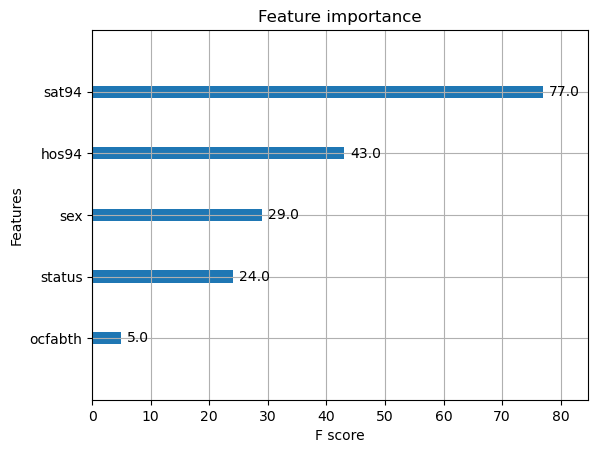

In [106]:
##visualize and comment on the covariates of these individuals 
from xgboost import plot_importance, XGBRegressor

df_diff = df_least.append(df_most)

xgb_most = XGBRegressor()
xgb_most.fit(df_diff[covariates], df_diff['hos96'])
plot_importance(xgb_most)


As in the previous week, we see that the most important covariates to determine the effect of treatment are the ones related to the past clinical history of the patient. 